## Estimate the activity of a simulated surface

#### Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

from tqdm.notebook import tqdm

#### Simulate HEA surface

In [2]:
# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 200, 200, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

HEA_surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates + mixed_sites
HEA_surface = precompute_binding_energies_SPEED2(HEA_surface, dim_x, dim_y, models)

#### Estimate activity of each site

In [3]:
# Make a function, that takes a surface in and returns it with a new
# matrix representing the activities on each site

# Decisions based on deltaG I guess
# Go through all indexes (x, y) and check for any negtive H neighb
# binding energies

/Users/marcusnorgaardweng/Documents/Kurser/Speciale/CatalysisThesis/Notebooks/../scripts/functions.py:2140: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


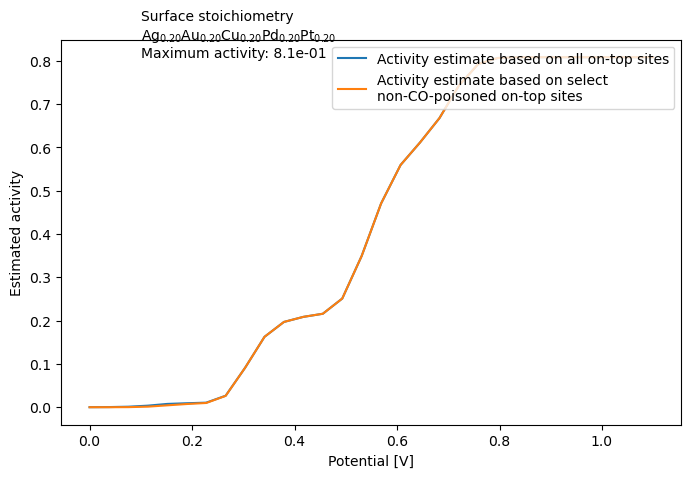

In [5]:
stoichiometry = [0.2, 0.2, 0.2, 0.2, 0.2]
#stoichiometry = [0.2, 0.2, 0.599, 0.0, 0.01]
#stoichiometry = [0.2, 0.2, 0.598, 0.01, 0.01]
#stoichiometry = [0.0, 0.1, 0.0, 0.9, 0.0]
#stoichiometry = [0.8, 0.0, 0.0, 0.0, 0.2]
#stoichiometry = [0.35, 0.05, 0.3 , 0.  , 0.3 ]

activity_dict = activity_of_surface(stoichiometry, V_min=-0.0, V_max=1.1, SPEED=False)
filename = "testington.png"
activity_plot(activity_dict, filename)

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_14182/1583939377.py:114: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


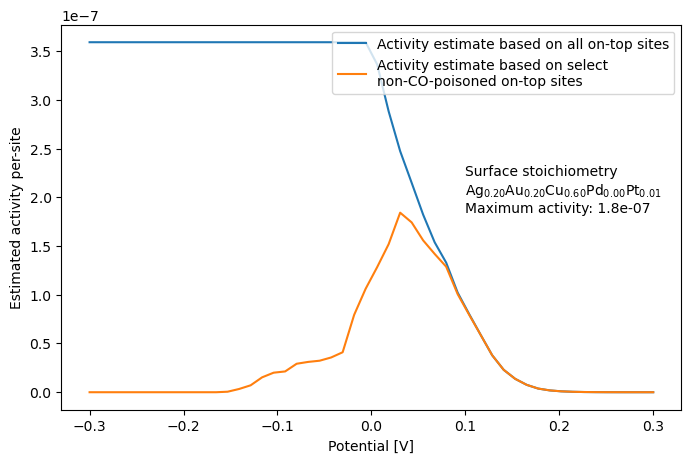

In [144]:
activity_plot(activity_dict)

In [2]:
import scipy
import itertools as it

# Molar fractions with all five metals
molar_fractions_001 = get_molar_fractions(0.01, 5)
molar_fractions_005 = get_molar_fractions(0.05, 5)
molar_fractions_010 = get_molar_fractions(0.10, 5)
molar_fractions_020 = get_molar_fractions(0.20, 5)

# Molar fractions with just three metals - the others at 0
molar_fractions_PtAgAu = get_molar_fractions(0.05, 3)
molar_fractions_PdAgAu = get_molar_fractions(0.05, 3)
molar_fractions_PtAgCu_005 = get_molar_fractions(0.05, 3)
molar_fractions_PtAgCu_003 = get_molar_fractions(0.03, 3)
molar_fractions_PtAgCu_002 = get_molar_fractions(0.02, 3)

# Put in the non-contributing metals
molar_fractions_PtAgAu = np.array([molar_fractions_PtAgAu.T[0], molar_fractions_PtAgAu.T[1], np.zeros(len(molar_fractions_PtAgAu)), np.zeros(len(molar_fractions_PtAgAu)), molar_fractions_PtAgAu.T[2]]).T
molar_fractions_PdAgAu = np.array([molar_fractions_PdAgAu.T[0], molar_fractions_PdAgAu.T[1], np.zeros(len(molar_fractions_PdAgAu)), molar_fractions_PdAgAu.T[2], np.zeros(len(molar_fractions_PdAgAu))]).T
molar_fractions_PtAgCu_005 = np.array([molar_fractions_PtAgCu_005.T[0], np.zeros(len(molar_fractions_PtAgCu_005)), molar_fractions_PtAgCu_005.T[1], np.zeros(len(molar_fractions_PtAgCu_005)), molar_fractions_PtAgCu_005.T[2]]).T
molar_fractions_PtAgCu_003 = np.array([molar_fractions_PtAgCu_003.T[0], np.zeros(len(molar_fractions_PtAgCu_003)), molar_fractions_PtAgCu_003.T[1], np.zeros(len(molar_fractions_PtAgCu_003)), molar_fractions_PtAgCu_003.T[2]]).T
molar_fractions_PtAgCu_002 = np.array([molar_fractions_PtAgCu_002.T[0], np.zeros(len(molar_fractions_PtAgCu_002)), molar_fractions_PtAgCu_002.T[1], np.zeros(len(molar_fractions_PtAgCu_002)), molar_fractions_PtAgCu_002.T[2]]).T

# Ag, Au and Cu at the same probability, Pt and Pd independent # To put 3 metals on one axis, I just need to search for the ones in 005 where a, b, c are equal to eachother
molar_fractions_AgAuCu_PdPt_001 = []

for molar_fraction in molar_fractions_001:
    if molar_fraction[0] == molar_fraction[1] == molar_fraction[2]:
        molar_fractions_AgAuCu_PdPt_001.append(molar_fraction)
molar_fractions_AgAuCu_PdPt_001 = np.array(molar_fractions_AgAuCu_PdPt_001)

#### Estimating the activity of a stoichiometry

In [22]:
stoichiometry = [0.2, 0.2, 0.599, 0.0, 0.01]

activity_dict = activity_of_surface(stoichiometry, V_min=-0.1, V_max=0.1, SPEED=True)
print(activity_dict["special_max_j"])
print(activity_dict["special_max_eU"])

1.5338591765612364e-07
0.05714285714285716


## Brute-forcing through stoichiometries

In [4]:
estimated_activities = []
estimated_max_eUs = []

for stoichiometry in tqdm(molar_fractions_PtAgCu_003):
    activity_dict = activity_of_surface(stoichiometry, V_min=-0.15, V_max=0.2, SPEED=True)
    #print("j: " + str(activity_dict["special_max_j"]))
    #print("max eU: " + str(activity_dict["special_max_eU"]))

    estimated_activities.append(activity_dict["special_max_j"])
    estimated_max_eUs.append(activity_dict["special_max_eU"])

filename = "PtAgCu_003_activities_redo.csv"

save_activities_csv(filename, molar_fractions_PtAgCu_003, estimated_activities, estimated_max_eUs)

  0%|          | 0/595 [00:00<?, ?it/s]

Data has been saved to ../Activity_Estimation/PtAgCu_003_activities_redo.csv


In [5]:
estimated_activities = []
estimated_max_eUs = []

for stoichiometry in tqdm(molar_fractions_PtAgCu_002):
    activity_dict = activity_of_surface(stoichiometry, V_min=-0.15, V_max=0.2, SPEED=True)
    #print("j: " + str(activity_dict["special_max_j"]))
    #print("max eU: " + str(activity_dict["special_max_eU"]))

    estimated_activities.append(activity_dict["special_max_j"])
    estimated_max_eUs.append(activity_dict["special_max_eU"])

filename = "PtAgCu_002_activities_redo.csv"

save_activities_csv(filename, molar_fractions_PtAgCu_002, estimated_activities, estimated_max_eUs)

  0%|          | 0/1326 [00:00<?, ?it/s]

Data has been saved to ../Activity_Estimation/PtAgCu_002_activities_redo.csv


In [5]:
# Assuming you have three lists: molar_fractions_020, estimated_activities, estimated_max_eUs
def save_activities_csv(filename, molar_fractions, estimated_activities, estimated_max_eUs):
    # Specify the file name
    csv_file_name = "../Activity_Estimation/" + filename
    #filename = "molar_fractions_PtAgAu_activity.csv"

    # Combine the lists into rows
    data = zip(molar_fractions, estimated_activities, estimated_max_eUs)

    # Write to CSV file
    with open(csv_file_name, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        
        # Write header if needed
        csv_writer.writerow(['Molar_Fraction', 'Estimated_Activities', 'Estimated_Max_eUs'])
        
        # Write data
        csv_writer.writerows(data)

    print(f'Data has been saved to {csv_file_name}')
    return None


## Estimating the activity of "special" structured surfaces

### 1/3 Optimal swim ring surface

In [6]:
# I need to create the surfaces (Already done in the 2nd swim ring notebook)
# and put them into the activity estimateur
metals_A = ["Pt", "Pd"]
metals_B = ["Cu", "Ag", "Au"]

metal_AB = []
metal_AB_max_j = []
metal_AB_max_eU = []

# Make the data for all metal combinations
for metal_A in metals_A:
    for metal_B in metals_B:
        print(metal_A + metal_B)
        metal_AB.append(metal_A + metal_B)
        # Should I plot it directly? Maybe easier than making an intermedian storage medium
        SWR_surface = initialize_swim_surface([metal_A], [metal_B], dim_x, dim_y)
        SWR_surface = precompute_binding_energies_SPEED(SWR_surface, dim_x, dim_y, models)
        activity_dict = activity_directly_from_surface(SWR_surface, n_points=50, V_min=-0.15, V_max=0.2)
        metal_AB_max_j.append(activity_dict["special_max_j"])
        metal_AB_max_eU.append(activity_dict["special_max_eU"])

PtCu
PtAg
PtAu
PdCu
PdAg
PdAu


In [7]:
for n in range(len(metal_AB)):
    print(metal_AB[n])
    print(metal_AB_max_j[n])
    print(metal_AB_max_eU[n])

PtCu
2.765218734741211e-05
0.021428571428571436
PtAg
4.353115558624267e-06
0.07857142857142857
PtAu
4.323218345642089e-06
0.08571428571428572
PdCu
7.385403478110674e-12
0.09285714285714286
PdAg
1.550246452097781e-11
0.06428571428571428
PdAu
3.881778098957511e-14
-0.021428571428571436


In [3]:
# Det her 
for n in range(len(metal_AB)):
    print(metal_AB[n])
    print(metal_AB_max_j[n])
    print(metal_AB_max_eU[n])

PtCu
2.778070640563965e-05
0.021428571428571436
PtAg
4.3596076965332035e-06
0.07857142857142857
PtAu
4.296271324157715e-06
0.07142857142857142
PdCu
7.385316621366656e-12
0.09285714285714286
PdAg
1.551301647850778e-11
0.06428571428571428
PdAu
3.909274326474588e-14
-0.021428571428571436


In [13]:
for n in range(len(metal_AB)):
    print(metal_AB[n])
    print(metal_AB_max_j[n])
    print(metal_AB_max_eU[n])

PtCu
4.0435302253172266e-10
0.07857142857142857
PtAg
1.2303848564624787e-05
0.04999999999999999
PtAu
5.716592073440552e-06
0.09285714285714286
PdCu
8.368141379833104e-11
0.1571428571428571
PdAg
3.465594602403144e-11
0.2
PdAu
1.178282138525333e-13
0.14285714285714288


In [11]:
for n in range(len(metal_AB)):
    print(metal_AB[n])
    print(metal_AB_max_j[n])
    print(metal_AB_max_eU[n])


PtCu
4.0435302253172266e-10
PtAg
1.1833424866199493e-05
PtAu
5.91525137424469e-06
PdCu
8.368141379833104e-11
PdAg
3.4453654507160535e-11
PdAu
1.2195698895212104e-13


In [6]:
activity_dict = activity_directly_from_surface(SWR_surface, n_points=50, V_min=-0.15, V_max=0.2)

### 1/3 Random surface

In [8]:
metals_A = ["Pt", "Pd"]
metals_B = ["Cu", "Ag", "Au"]

metal_AB = []
metal_AB_max_j = []
metal_AB_max_eU = []

# Make the data for all metal combinations
for metal_A in metals_A:
    for metal_B in metals_B:
        metal_AB.append(metal_A + metal_B)
        split = [0, 0, 0, 0, 0]
        if metal_A == "Pt":
            split[4] += 1/3
        if metal_A == "Pd":
            split[3] += 1/3
        if metal_B == "Ag":
            split[0] += 2/3
        if metal_B == "Au":
            split[1] += 2/3
        if metal_B == "Cu":
            split[2] += 2/3

        # Initialize the bimetal surface
        BM_surface = initialize_surface(dim_x, dim_y, metals, split)

        # Should I plot it directly? Maybe easier than making an intermedian storage medium
        BM_surface = initialize_swim_surface([metal_A], [metal_B], dim_x, dim_y)
        BM_surface = precompute_binding_energies_SPEED(BM_surface, dim_x, dim_y, models)

        activity_dict = activity_directly_from_surface(SWR_surface, n_points=50, V_min=-0.15, V_max=0.2)
        metal_AB_max_j.append(activity_dict["special_max_j"])
        metal_AB_max_eU.append(activity_dict["special_max_eU"])

In [12]:
for n in range(len(metal_AB)):
    print(metal_AB[n])
    print(metal_AB_max_j[n])
    print(metal_AB_max_eU[n])

PtCu
3.881778098957511e-14
-0.021428571428571436
PtAg
3.881778098957511e-14
-0.021428571428571436
PtAu
3.881778098957511e-14
-0.021428571428571436
PdCu
3.881778098957511e-14
-0.021428571428571436
PdAg
3.881778098957511e-14
-0.021428571428571436
PdAu
3.881778098957511e-14
-0.021428571428571436


In [19]:
CO2H2 = molecules_dict["CO2"] + molecules_dict["H2"]
CO2 = molecules_dict["CO2"]
H2 =  molecules_dict["H2"]
print(f"{CO2H2:.2f}")

-25.83


In [11]:
HCOOH = molecules_dict["CH2O2"]
print(f"{HCOOH:.2f}")

-25.75


In [16]:
-molecules_dict["CO2"]-1/2*molecules_dict["H2"]

22.4910788212545

In [17]:
1/2*molecules_dict["H2"]-molecules_dict["CH2O2"]

22.41544032114134

In [18]:
(-molecules_dict["CO2"]-1/2*molecules_dict["H2"]) - (1/2*molecules_dict["H2"]-molecules_dict["CH2O2"])

0.0756385001131612

# Counting activity estimation

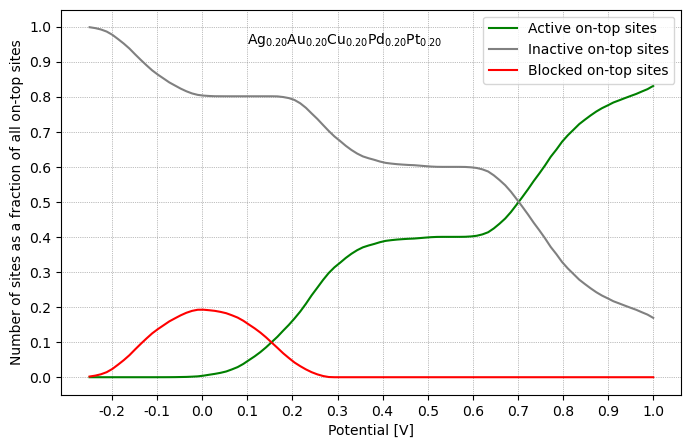

In [69]:
# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 200, 200, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

HEA_surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates + mixed_sites
HEA_surface = precompute_binding_energies_SPEED2(HEA_surface, dim_x, dim_y, models)

# Calculate 
potential_range, active_list, inactive_list, blocked_list = counting_activity_scan(HEA_surface, -0.25, 1.0, 100)

# Plot and save
filename = "HEA_even.png"
counting_activity_plot(potential_range, active_list, inactive_list, blocked_list, split)

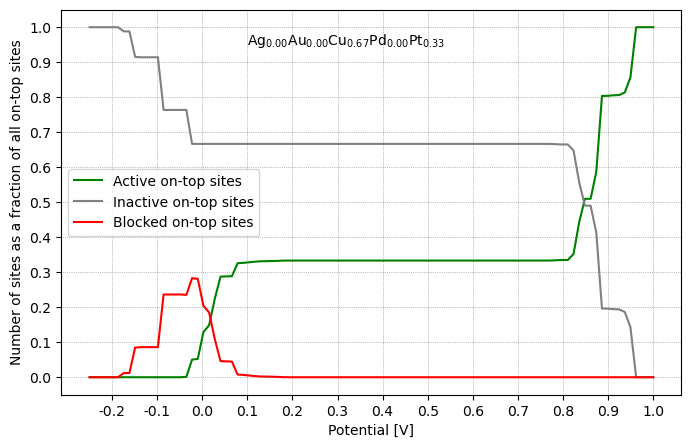

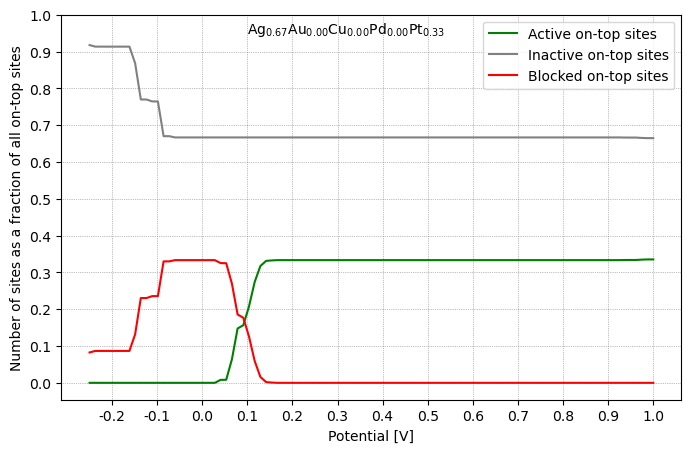

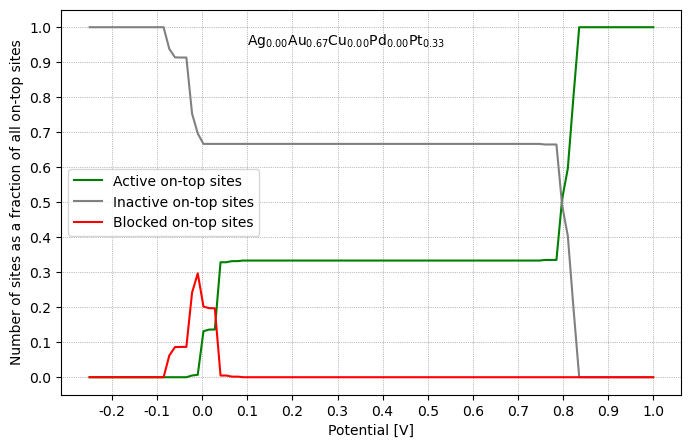

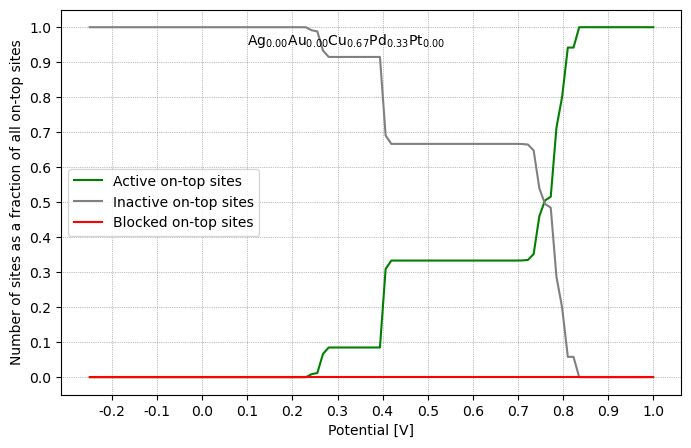

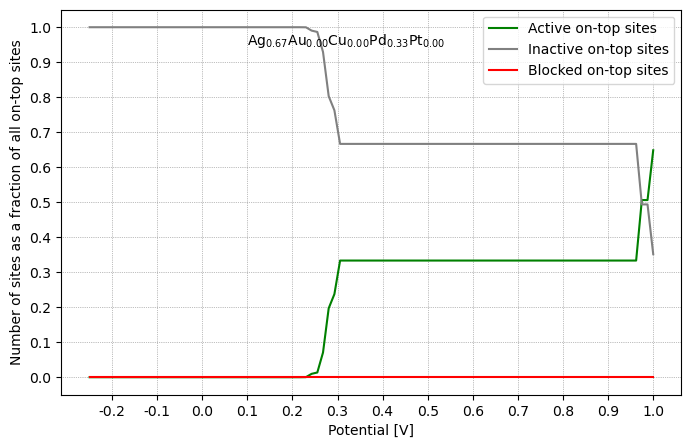

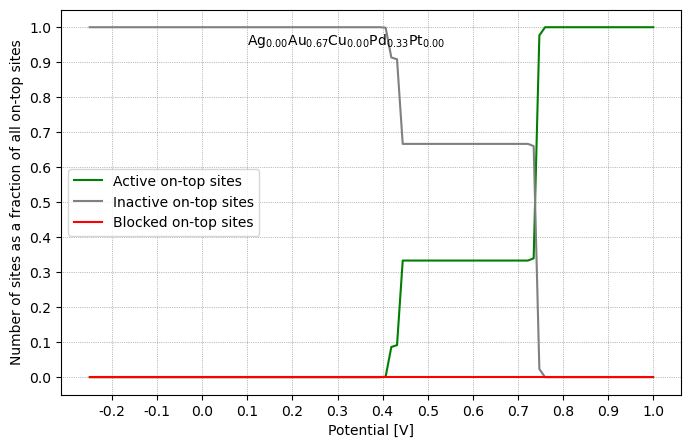

In [76]:
metals_A = ["Pt", "Pd"]
metals_B = ["Cu", "Ag", "Au"]
filename = "testingtron.png"
for metal_A in metals_A:
    for metal_B in metals_B:
        split = [0, 0, 0, 0, 0]
        if metal_A == "Pt":
            split[4] += 1/3
        if metal_A == "Pd":
            split[3] += 1/3
        if metal_B == "Ag":
            split[0] += 2/3
        if metal_B == "Au":
            split[1] += 2/3
        if metal_B == "Cu":
            split[2] += 2/3
        SWR_surface = initialize_swim_surface([metal_A], [metal_B], dim_x, dim_y)
        SWR_surface = precompute_binding_energies_SPEED(SWR_surface, dim_x, dim_y, models)

        # Calculate 
        potential_range, active_list, inactive_list, blocked_list = counting_activity_scan(SWR_surface, -0.25, 1.0, 100)

        # Plot and save
        filename = metal_A+metal_B+".png"
        counting_activity_plot(potential_range, active_list, inactive_list, blocked_list, split)

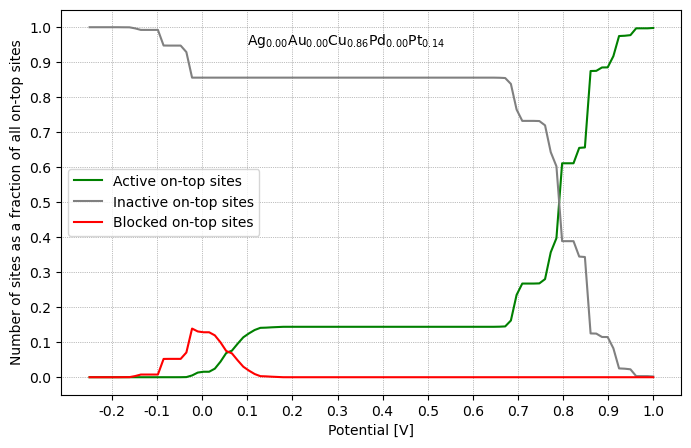

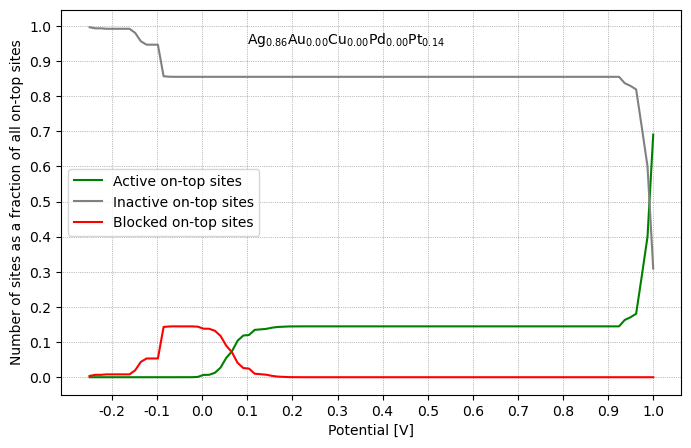

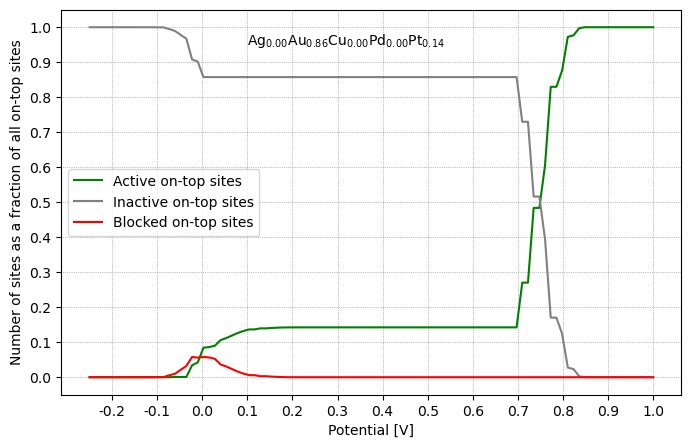

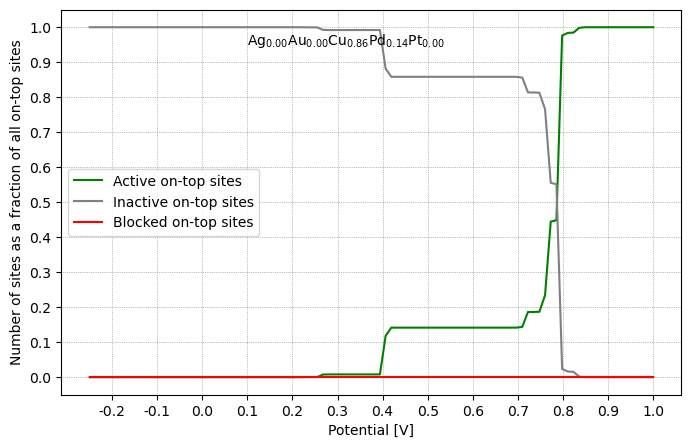

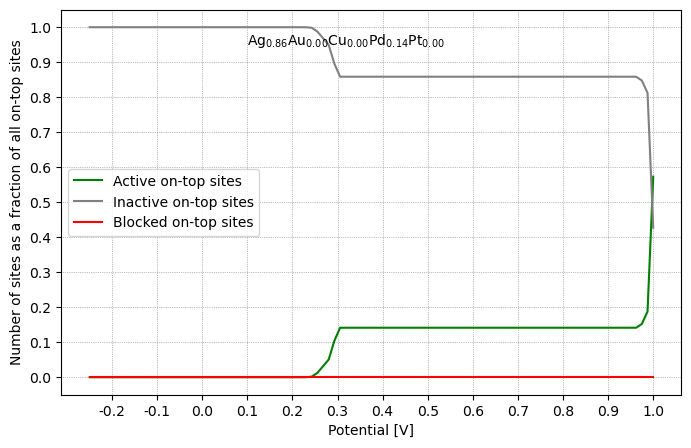

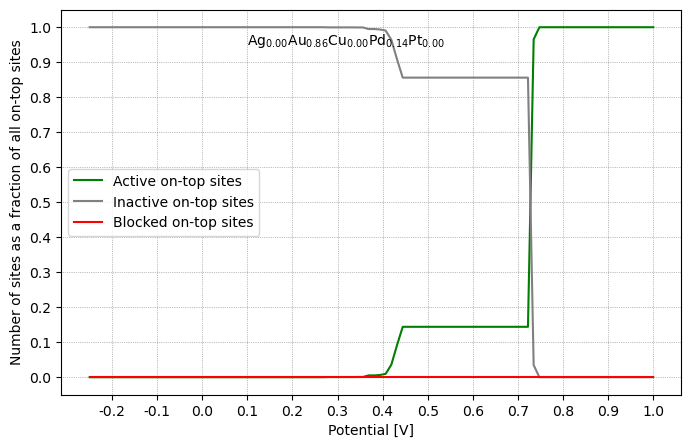

In [80]:
metals_A = ["Pt", "Pd"]
metals_B = ["Cu", "Ag", "Au"]

# Make the data for all metal combinations
for metal_A in metals_A:
    for metal_B in metals_B:
        split = [0, 0, 0, 0, 0]
        if metal_A == "Pt":
            split[4] += 1/7
        if metal_A == "Pd":
            split[3] += 1/7
        if metal_B == "Ag":
            split[0] += 6/7
        if metal_B == "Au":
            split[1] += 6/7
        if metal_B == "Cu":
            split[2] += 6/7

        # Initialize the bimetal surface
        BM_surface = initialize_surface(dim_x, dim_y, metals, split)
        BM_surface = precompute_binding_energies_SPEED(BM_surface, dim_x, dim_y, models)

        # Calculate 
        potential_range, active_list, inactive_list, blocked_list = counting_activity_scan(BM_surface, -0.25, 1.0, 100)

        # Plot and save
        filename = metal_A+metal_B+"1_7_random.png"
        counting_activity_plot(potential_range, active_list, inactive_list, blocked_list, split)



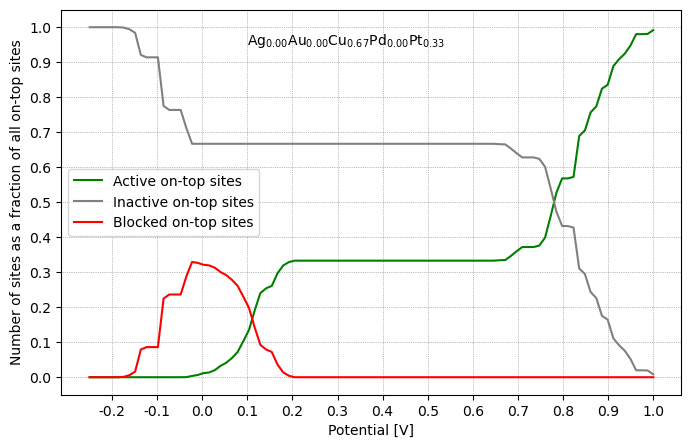

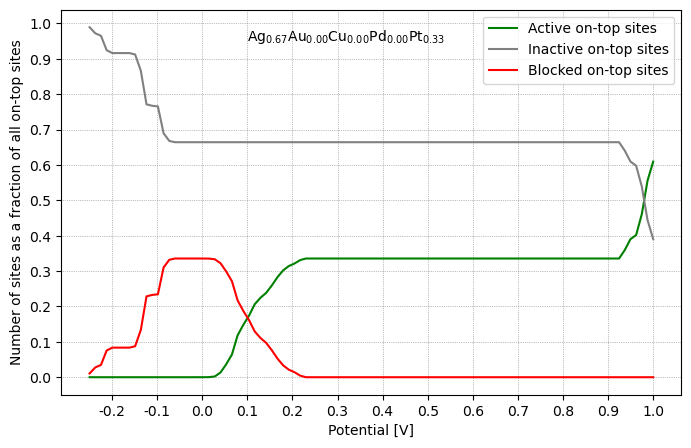

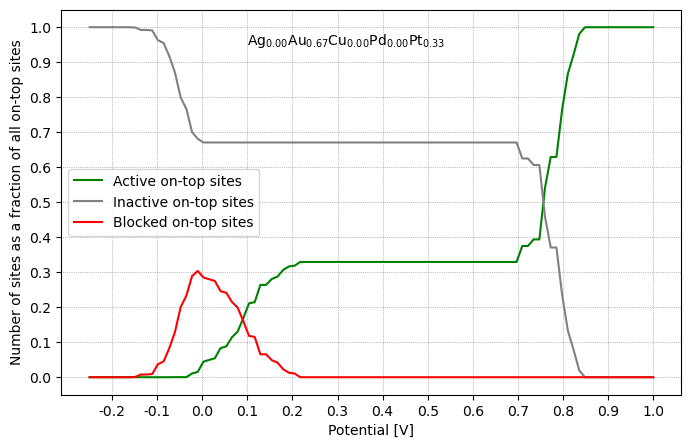

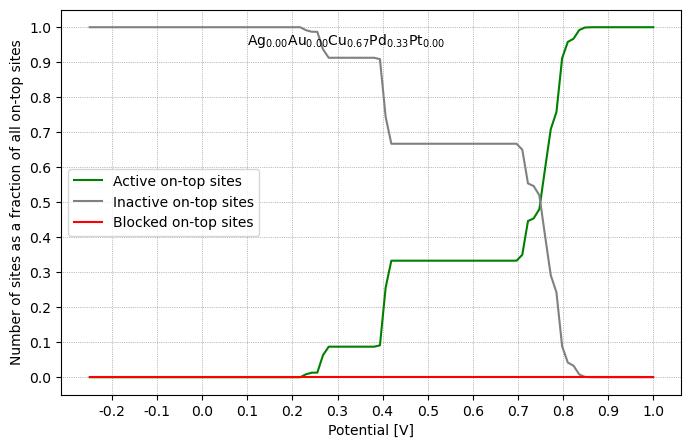

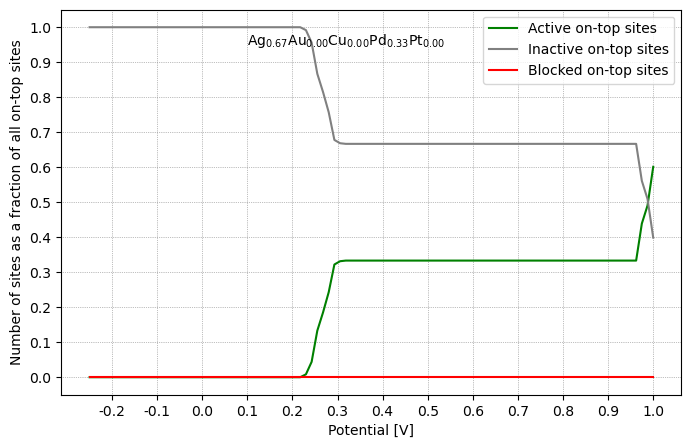

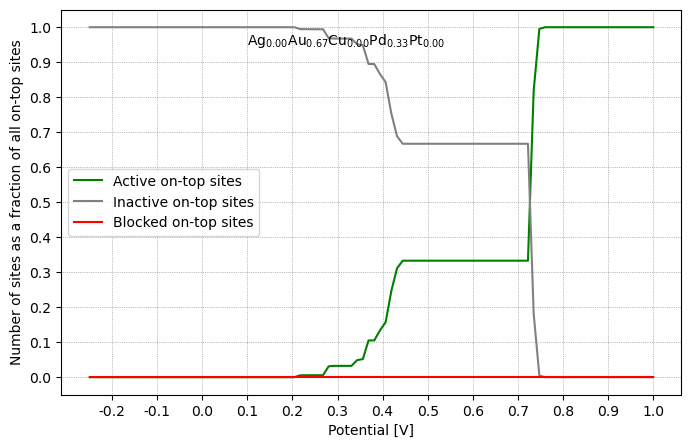

In [81]:
metals_A = ["Pt", "Pd"]
metals_B = ["Cu", "Ag", "Au"]

# Make the data for all metal combinations
for metal_A in metals_A:
    for metal_B in metals_B:
        split = [0, 0, 0, 0, 0]
        if metal_A == "Pt":
            split[4] += 1/3
        if metal_A == "Pd":
            split[3] += 1/3
        if metal_B == "Ag":
            split[0] += 2/3
        if metal_B == "Au":
            split[1] += 2/3
        if metal_B == "Cu":
            split[2] += 2/3

        # Initialize the bimetal surface
        BM_surface = initialize_surface(dim_x, dim_y, metals, split)
        BM_surface = precompute_binding_energies_SPEED(BM_surface, dim_x, dim_y, models)

        # Calculate 
        potential_range, active_list, inactive_list, blocked_list = counting_activity_scan(BM_surface, -0.25, 1.0, 100)

        # Plot and save
        filename = metal_A+metal_B+"1_3_random.png"
        counting_activity_plot(potential_range, active_list, inactive_list, blocked_list, split)



In [72]:
# In: Surface + potential
# Out: Number of active and number of inactive and number of blocked sites

def counting_activity(surface, potential):
    H_G_values    = surface["H_G"] + potential
    COOH_G_values = surface["COOH_G"] - potential

    active = 0
    inactive = sum(1 for value in COOH_G_values.flatten() if value > 0) #Counts number of binding COOH binding sites
    blocked = 0

    for idx_x in range(dim_x):
        for idx_y in range(dim_y):
            # Check if any of the neighbouring hollow sites could house an H
            security_clearence = True # This being true means NO dangerous H neighbours
            for x_diff, y_diff in [(0, 0), (-1, 0), (0, -1)]:
                neighbour_H_G = H_G_values[idx_x+x_diff, idx_y+y_diff]
                if neighbour_H_G < 0:
                    security_clearence = False # This being false means there is at least one dangerous neighbour
                    continue
            
            if COOH_G_values[idx_x][idx_y] > 0:
                COOH_binds = False
            if COOH_G_values[idx_x][idx_y] < 0:
                COOH_binds = True

            if security_clearence and COOH_binds:
                # There is a safe on-top site and COOH binds - SIUUUUU
                active += 1
            if not security_clearence and COOH_binds: #COOH would bind if it could but it can't because of block
                # The site is blocked
                blocked += 1

    return active, inactive, blocked

def counting_activity_scan(surface, Vmin, Vmax, points):
    """Takes a surface and a potential, and returns counts of:
    Active_list: Sites where COOH binds and no neighbouring H
    Inactive_list: Sites where COOH wouldn't bind no matter the blocking
    Blocked_list: Sites where COOH would bind but blocked by H disprop
    It doesn't count Inactive AND blocked. That group is in inactive"""

    active_list = []
    inactive_list = []
    blocked_list = []
    potential_range = np.linspace(Vmin, Vmax, points)
    for potential in potential_range:
        active, inactive, blocked = counting_activity(surface, potential)
        active_list.append(active)
        inactive_list.append(inactive)
        blocked_list.append(blocked)
    return np.array(potential_range), np.array(active_list), np.array(inactive_list), np.array(blocked_list)

def counting_activity_plot(potential_range, active_list, inactive_list, blocked_list, split):
    fig, ax = plt.subplots(figsize = (8, 5))
    n_sites = 200*200
    ax.plot(potential_range, active_list/n_sites,   c = "green", label = "Active on-top sites")
    ax.plot(potential_range, inactive_list/n_sites, c = "grey", label = "Inactive on-top sites")
    ax.plot(potential_range, blocked_list/n_sites,  c = "r", label = "Blocked on-top sites")

    # Set the major ticks and tick labels
    ax.set_xticks([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    # Put the stoichiometry in there
    ax.text(x=0.10, y=0.95, s = stoch_to_string(split))

    # Set axis labels
    ax.set_xlabel('Potential [V]')
    ax.set_ylabel('Number of sites as a fraction of all on-top sites')

    # Set the grid lines
    ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

    ax.legend()

    plt.savefig("../Activity_Estimation/Counting_Sites_" + filename, dpi = 400, bbox_inches = "tight")
    plt.show()
    return None